# Face Emotion Analysis

### importing modules

In [2]:
import sys
import os
import fnmatch

import numpy as np
import pandas as pd
from PIL import Image

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append('../modules/')
import case_stats as cs

settings for plot formatting

In [3]:
myPal = sns.color_palette("Set1")
sns.set_context("talk", font_scale=1.4)
sns.set_style("white")

settings for group labelling

In [4]:
labelCoding = {'JB':0,'A':1}
myGLabels={'JB':'JB','A':'controls'}

### get logfiles

In [5]:
def getLogfile(whichfolder, whichexperiment):

    loglist = []
    for fileName in os.listdir(whichfolder):
        if fnmatch.fnmatch(fileName, whichexperiment):
            loglist.append(whichfolder+fileName)
    return loglist

In [6]:
logList = getLogfile('../faceEmotion/experiment/data/','*.csv')
logList.sort()

Example:

In [7]:
logList

['../faceEmotion/experiment/data/A_10_facesParametric_2015_Sep_20_1307.csv',
 '../faceEmotion/experiment/data/A_11_facesParametric_2015_Sep_25_1753.csv',
 '../faceEmotion/experiment/data/A_12_facesParametric_2015_Oct_11_1221.csv',
 '../faceEmotion/experiment/data/A_13_facesParametric_2015_Oct_11_1620.csv',
 '../faceEmotion/experiment/data/A_14_facesParametric_2015_Nov_01_1250.csv',
 '../faceEmotion/experiment/data/A_15_facesParametric_2015_Nov_02_1800.csv',
 '../faceEmotion/experiment/data/A_16_facesParametric_2015_Nov_04_2015.csv',
 '../faceEmotion/experiment/data/A_17_facesParametric_2015_Oct_20_1435.csv',
 '../faceEmotion/experiment/data/A_1_facesParametric_2015_Aug_23_1225.csv',
 '../faceEmotion/experiment/data/A_2_facesParametric_2015_Sep_13_1402.csv',
 '../faceEmotion/experiment/data/A_3_facesParametric_2015_Sep_02_1456.csv',
 '../faceEmotion/experiment/data/A_4_facesParametric_2015_Sep_02_1917.csv',
 '../faceEmotion/experiment/data/A_5_facesParametric_2015_Sep_06_1239.csv',
 '..

In [8]:
df = pd.read_csv(logList[-1])

### Extract Responses from logfile

In [9]:
def getBasicResps(fileName):
    df = pd.read_csv(fileName)

    ## merge scales into one column
    
    # convert None to NaN
    df = df.replace(r'None', np.nan, regex=True)
    df['basicRating1.response'] = df['basicRating1.response'].fillna(df['basicRating2.response']).fillna(df['basicRating3.response']).fillna(df['basicRating4.response'])
    df['basicRating1.rt'] = df['basicRating1.rt'].fillna(df['basicRating2.rt']).fillna(df['basicRating3.rt']).fillna(df['basicRating4.rt'])
   
    # boil down to just the essentials
    thisDf = pd.concat([df['img'],
                        df['basicRating1.response'],
                        df['basicRating1.rt']
                       ],axis=1)
    
    return thisDf[1:85]

Example: 

In [10]:
getBasicResps(logList[-1]).head()

,img,basicRating1.response,basicRating1.rt
1,./basicStim/07F_DI_O.jpg,DIS,4.694
2,./basicStim/21M_AN_O.jpg,ANG,2.516
3,./basicStim/34M_HA_O.jpg,HAP,3.038
4,./basicStim/01F_HA_O.jpg,HAP,4.044
5,./basicStim/07F_FE_O.jpg,DIS,3.888


## Get Conditions from Filenames

In [11]:
def getConds(df):
    
    df['conds'] = [entry[entry.find('_')+1:entry.rfind('_')] for entry in df['img'] ]
    df = df.sort_values(by='conds')
    df.index = [df['conds'],df.index]
    
    return df

Example:

In [12]:
getConds(getBasicResps(logList[-1])).head()

img basicRating1.response basicRating1.rt conds
conds                                                                         
AN    28  ./basicStim/24M_AN_O.jpg                   ANG           1.038    AN
      2   ./basicStim/21M_AN_O.jpg                   ANG           2.516    AN
      35  ./basicStim/01F_AN_O.jpg                   ANG           2.172    AN
      78  ./basicStim/03F_AN_O.jpg                   ANG           2.885    AN
      74  ./basicStim/36M_AN_O.jpg                   ANG           1.269    AN

### Evaluate whether response is correct or not (binary)

In [13]:
def addEval(df):
    
    resp = []
    for index,entry in enumerate( df['basicRating1.response'] ):
        # for each correct response, append a one
        if entry=='ANG' and df['conds'][index]=='AN':
            resp.append(1)
        elif entry=='ANG' and df['conds'][index]=='AN':
            resp.append(1)
        elif entry=='DIS' and df['conds'][index]=='DI':
            resp.append(1)
        elif entry=='FEA' and df['conds'][index]=='FE':
            resp.append(1)
        elif entry=='HAP' and df['conds'][index]=='HA':
            resp.append(1)
        elif entry=='NTR' and df['conds'][index]=='NE':
            resp.append(1)
        elif entry=='SAD' and df['conds'][index]=='SA':
            resp.append(1)
        elif entry=='SUP' and df['conds'][index]=='SP':
            resp.append(1)   
        # all other responses must be incorrect; we append a zero
        else:
            resp.append(0)

    df['resp'] = resp
        
    return df

Example:

In [14]:
addEval(getConds(getBasicResps(logList[-1]))).head()

img basicRating1.response basicRating1.rt  \
conds                                                                      
AN    28  ./basicStim/24M_AN_O.jpg                   ANG           1.038   
      2   ./basicStim/21M_AN_O.jpg                   ANG           2.516   
      35  ./basicStim/01F_AN_O.jpg                   ANG           2.172   
      78  ./basicStim/03F_AN_O.jpg                   ANG           2.885   
      74  ./basicStim/36M_AN_O.jpg                   ANG           1.269   

         conds  resp  
conds                 
AN    28    AN     1  
      2     AN     1  
      35    AN     1  
      78    AN     1  
      74    AN     1

### Average over trials

Count and average the correct responses. Add a participant number to the index.

In [15]:
def getAvg(df,p):
    meanDf = pd.DataFrame([df.loc[cond]['resp'].mean()] for cond in df.index.levels[0])
    meanDf['cond'] = [cond for cond in df.index.levels[0]]
    meanDf.index = [[p]*len(meanDf.index), meanDf['cond'] ]
    meanDf.index.names = ['id','cond']
    
    return meanDf

Example:

In [16]:
getAvg(addEval(getConds(getBasicResps(logList[-1]))),'JB').head()

0 cond
id cond               
JB AN    0.916667   AN
   DI    0.916667   DI
   FE    0.666667   FE
   HA    1.000000   HA
   NE    0.916667   NE

### Do all this for a participant

Takes all the functions from above and applies them directly to a logfile. Also gets the participant number form the logfile name.

In [17]:
def makeOne(fileName):
    df = getBasicResps(fileName)

    condDf = getConds(df)
    
    respDf = addEval(condDf)
    
    p = fileName[fileName.rfind('/')+1:fileName.find('faces')-1]
    avgDf = getAvg(respDf,p)
    return avgDf

Example:

In [18]:
makeOne(logList[-1])

0 cond
id     cond               
JB_001 AN    0.916667   AN
       DI    0.916667   DI
       FE    0.666667   FE
       HA    1.000000   HA
       NE    0.916667   NE
       SA    0.916667   SA
       SP    0.833333   SP

## Do this for whole group

In [19]:
def makeBig(loglist):
    for logfile in loglist:
        thisDf = makeOne(logfile)
        withinDf = thisDf.drop('cond',1).unstack()
        
        try:
            bigDf = pd.concat([bigDf,withinDf])
        except:
            bigDf = withinDf
    
    groups = [a.split('_')[0] for a in bigDf.index]
    
    bigDf.index = [groups, bigDf.index ]
    bigDf.index.names = ['group','id']
    bigDf.columns = bigDf.columns.droplevel()
    return bigDf

This is the main table for the analyses:

In [20]:
bigDf = makeBig(logList)

In [26]:
bigDf.mean(axis=1)

group  id    
A      A_10      0.785714
       A_11      0.845238
       A_12      0.702381
       A_13      0.833333
       A_14      0.809524
       A_15      0.702381
       A_16      0.833333
       A_17      0.892857
       A_1       0.726190
       A_2       0.857143
       A_3       0.750000
       A_4       0.547619
       A_5       0.821429
       A_6       0.833333
       A_7       0.809524
       A_8       0.857143
       A_9       0.797619
JB     JB_001    0.880952
dtype: float64

Save as csv for later re-use:

In [24]:
bigDf.to_csv('../faceEmotion/output/basicExpressions.csv')

### collect and save main results

In [36]:
meanDf = pd.DataFrame(bigDf.mean(axis=1),columns=['mean'])
meanDf.index = [[x,'JB']['JB' in x] for x in meanDf.index.get_level_values(1)]
meanDf

,mean
A_10,0.785714
A_11,0.845238
A_12,0.702381
A_13,0.833333
A_14,0.809524
A_15,0.702381
A_16,0.833333
A_17,0.892857
A_1,0.726190
A_2,0.857143


raw data

In [56]:
raw_df = meanDf.loc[['JB']].T * 100
raw_df.index = raw_df.index.get_level_values(0)
raw_df.columns = ['% correct']
raw_df

,% correct
mean,88.095238


percentile score

In [57]:
percentile_df = cs.make_percentile_df(meanDf,'JB')
percentile_df

,percentile,z
mean,87.49195,1.149958


ttest results

In [58]:
ttest_df = cs.make_tstats_df(meanDf,'JB')
ttest_df

,t,df,p
mean,1.08,16,0.294


save everything in one table

In [59]:
result_df = pd.concat([raw_df, percentile_df, ttest_df],axis=1)
# add hierarchy to index
result_df.index = [['Face evaluation']*result_df.shape[0], ['Emotion recognition']]
result_df

,,% correct,percentile,z,t,df,p
Face evaluation,Emotion recognition,88.095238,87.49195,1.149958,1.08,16,0.294


Save to file

In [60]:
result_df.to_csv('../reports/tables/emofaces_main_results.csv')

## Basic Plotting

In [26]:
def makeBar(bigDf):
    fig = plt.figure(figsize=(12,8))
    add = 0
    for index,group in enumerate(bigDf.index.levels[0]):

        plt.bar(np.arange(0,14,2)+add,
                bigDf.loc[group].mean(),
                yerr=bigDf.loc[group].std()/np.sqrt(len(bigDf.loc[group]))*1.96,
                color=myPal[labelCoding[group]],
                ecolor='k',
                label=group)

        add+=0.8

    plt.legend(loc='lower right',bbox_to_anchor=(1.2,0.1))
    plt.xticks(np.arange(0,14,2)+0.4, bigDf.columns )
    plt.ylim(0,1.05)
    sns.despine()
    plt.show()

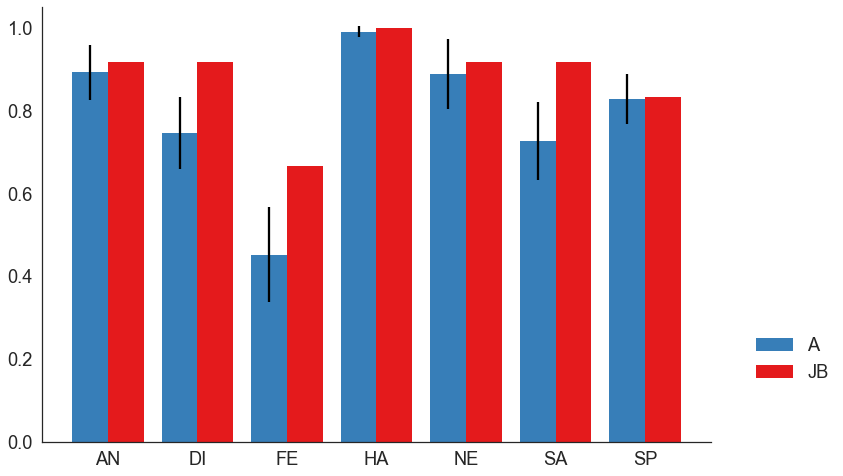

In [27]:
makeBar(bigDf)

## Responses with confusions

Extract information from dataFrame in a more systematic way:

In [28]:
def recodeResponses(df):
    g = []; e = []
    for i in df.index:
        thisImg = df.loc[i]['img']
        thisGender = thisImg[ thisImg.rfind('/')+3 ]
        thisEmo = thisImg[ thisImg.find('_')+1 : thisImg.find('_')+3 ]

        g.append(thisGender)
        e.append(thisEmo)
    
    df['fgender'] = g
    df['emo'] = e

    return df 

Example:

In [29]:
print logList[-1]

../faceEmotion/experiment/data/JB_001_facesParametric_2016_Oct_20_1313.csv


In [30]:
df = getBasicResps(logList[-1])

In [31]:
recodeResponses(df).head()

,img,basicRating1.response,basicRating1.rt,fgender,emo
1,./basicStim/07F_DI_O.jpg,DIS,4.694,F,DI
2,./basicStim/21M_AN_O.jpg,ANG,2.516,M,AN
3,./basicStim/34M_HA_O.jpg,HAP,3.038,M,HA
4,./basicStim/01F_HA_O.jpg,HAP,4.044,F,HA
5,./basicStim/07F_FE_O.jpg,DIS,3.888,F,FE


Get full range of responses to each expression:

In [32]:
def getAllResponses(df,p):
    
    d = {}

    # prepare dict
    for entry in df.index:
        d[df.loc[entry]['emo']] = { 'F':{'HAP':0,'SAD':0,'ANG':0,'FEA':0,'DIS':0,'SUP':0,'NTR':0},
                                   'M':{'HAP':0,'SAD':0,'ANG':0,'FEA':0,'DIS':0,'SUP':0,'NTR':0}
                                 }  
    # fill dict
    for entry in df.index:
        thisResp = df.loc[entry]['basicRating1.response']
        thisFace = df.loc[entry]['emo']
        thisFGender = df.loc[entry]['fgender']
        try:
            d[thisFace][thisFGender][thisResp] +=1
        except:
            pass


    bigDf = pd.DataFrame()
    for entry in d:
        thisDf = pd.DataFrame(d[entry])
        thisDf.index = [ [entry]*len(thisDf.index), thisDf.index ]
        bigDf = pd.concat([bigDf, thisDf])


    bigDf = bigDf.sort_index()
    bigDf = bigDf.T
    bigDf.index = [[p]*len(bigDf.index), bigDf.index]
    bigDf.index.names = ['pNum','fGender']

    return bigDf

Example:

In [33]:
getAllResponses(df,'JB')

AN                          DI         ...  SA          SP      \
             ANG DIS FEA HAP NTR SAD SUP ANG DIS FEA ... NTR SAD SUP ANG DIS   
pNum fGender                                         ...                       
JB   F         6   0   0   0   0   0   0   0   6   0 ...   0   6   0   0   0   
     M         5   0   0   0   0   1   0   0   5   0 ...   0   5   0   0   0   

                                  
             FEA HAP NTR SAD SUP  
pNum fGender                      
JB   F         1   0   0   0   5  
     M         1   0   0   0   5  

[2 rows x 49 columns]

In [34]:
pd.DataFrame( pd.DataFrame( getAllResponses(df,'JB').loc['JB'].loc['F'] ).unstack() )/6.*100

F                                                       
      ANG         DIS        FEA    HAP    NTR    SAD        SUP
AN  100.0    0.000000   0.000000    0.0    0.0    0.0   0.000000
DI    0.0  100.000000   0.000000    0.0    0.0    0.0   0.000000
FE    0.0   33.333333  66.666667    0.0    0.0    0.0   0.000000
HA    0.0    0.000000   0.000000  100.0    0.0    0.0   0.000000
NE    0.0    0.000000   0.000000    0.0  100.0    0.0   0.000000
SA    0.0    0.000000   0.000000    0.0    0.0  100.0   0.000000
SP    0.0    0.000000  16.666667    0.0    0.0    0.0  83.333333

### Showing full confusion matrix as heatmap

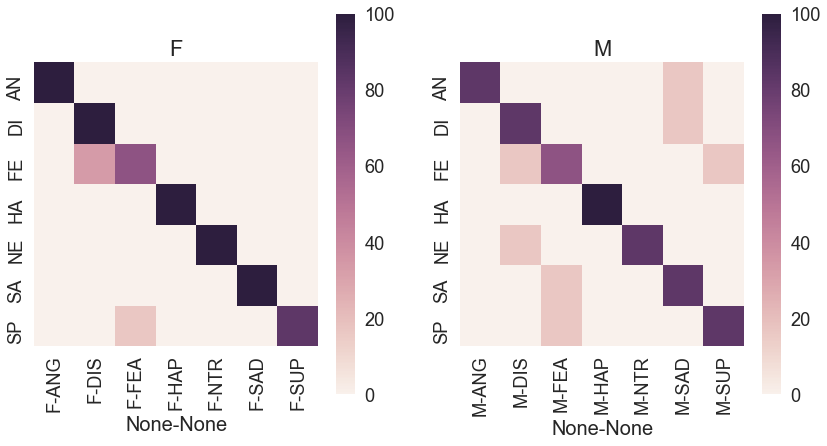

In [35]:
fig = plt.figure(figsize=(14,7))
for i,fGender in enumerate(['F','M']):
    confDf = pd.DataFrame( pd.DataFrame( getAllResponses(df,'JB').loc['JB'].loc[fGender] ).unstack() )/6.*100
    ax = plt.subplot('12'+str(i+1))
    sns.heatmap(confDf,square=True);
    ax.set_title(fGender)
plt.show()

### Do this for all participants

In [36]:
def confusionDf(loglist):
    allRespDf = pd.DataFrame()

    for logfile in loglist:
        
        rawDf = getBasicResps(logfile)
        pName = logfile[logfile.rfind('/')+1:logfile.find('_faces')]
        thisDf = getAllResponses( recodeResponses(rawDf),pName )

        allRespDf = pd.concat([allRespDf,thisDf])
    
    # some restructuring...
    allRespDf = allRespDf.unstack(1)
    groupIndex = [ x.split('_')[0] for x in allRespDf.index ]
    allRespDf.index = [ groupIndex,allRespDf.index  ]
    allRespDf.columns = allRespDf.columns.swaplevel(0, 2)
    allRespDf.sort_index(level=0, axis=1, inplace=True)
    allRespDf.columns = allRespDf.columns.swaplevel(1, 2)
    allRespDf.sort_index(level=0, axis=1, inplace=True)
    return allRespDf/6. # divide by number of trials in each condition (12 faces)

In [37]:
confDf = confusionDf(logList)

Example:

In [38]:
confDf.tail()

fGender           F                                                         \
                 AN                                           DI             
                ANG  DIS       FEA  HAP  NTR  SAD  SUP       ANG       DIS   
   pNum                                                                      
A  A_6     1.000000  0.0  0.000000  0.0  0.0  0.0  0.0  0.166667  0.833333   
   A_7     1.000000  0.0  0.000000  0.0  0.0  0.0  0.0  0.166667  0.833333   
   A_8     0.833333  0.0  0.166667  0.0  0.0  0.0  0.0  0.166667  0.833333   
   A_9     1.000000  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  1.000000   
JB JB_001  1.000000  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  1.000000   

fGender           ...            M                                          \
                  ...           SA                       SP                  
           FEA    ...          NTR       SAD       SUP  ANG  DIS       FEA   
   pNum           ...                                                        
A  A_6     0.0    ...     0.166667  0.500000  0.000000  0.0  0.0  0.000000   
   A_7     0.0    ...     0.000000  0.666667  0.166667  0.0  0.0  0.166667   
   A_8     0.0    ...     0.166667  0.833333  0.000000  0.0  0.0  0.000000   
   A_9     0.0    ...     0.166667  0.666667  0.166667  0.0  0.0  0.000000   
JB JB_001  0.0    ...     0.000000  0.833333  0.000000  0.0  0.0  0.166667   

fGender                                  
                                         
                HAP  NTR  SAD       SUP  
   pNum                                  
A  A_6     0.166667  0.0  0.0  0.833333  
   A_7     0.000000  0.0  0.0  0.833333  
   A_8     0.000000  0.0  0.0  1.000000  
   A_9     0.000000  0.0  0.0  1.000000  
JB JB_001  0.000000  0.0  0.0  0.833333  

[5 rows x 98 columns]

### Split the big plot into one for female, one for male faces

In [39]:
fConfDf = confDf['F']
mConfDf = confDf['M']

In [40]:
fConfDf.tail()

AN                                           DI            \
                ANG  DIS       FEA  HAP  NTR  SAD  SUP       ANG       DIS   
   pNum                                                                      
A  A_6     1.000000  0.0  0.000000  0.0  0.0  0.0  0.0  0.166667  0.833333   
   A_7     1.000000  0.0  0.000000  0.0  0.0  0.0  0.0  0.166667  0.833333   
   A_8     0.833333  0.0  0.166667  0.0  0.0  0.0  0.0  0.166667  0.833333   
   A_9     1.000000  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  1.000000   
JB JB_001  1.000000  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  1.000000   

                  ...      SA                  SP                           \
           FEA    ...     NTR       SAD  SUP  ANG  DIS       FEA       HAP   
   pNum           ...                                                        
A  A_6     0.0    ...     0.0  0.666667  0.0  0.0  0.0  0.000000  0.166667   
   A_7     0.0    ...     0.0  1.000000  0.0  0.0  0.0  0.000000  0.000000   
   A_8     0.0    ...     0.0  1.000000  0.0  0.0  0.0  0.333333  0.000000   
   A_9     0.0    ...     0.0  0.833333  0.0  0.0  0.0  0.166667  0.166667   
JB JB_001  0.0    ...     0.0  1.000000  0.0  0.0  0.0  0.166667  0.000000   

                               
           NTR  SAD       SUP  
   pNum                        
A  A_6     0.0  0.0  0.833333  
   A_7     0.0  0.0  1.000000  
   A_8     0.0  0.0  0.666667  
   A_9     0.0  0.0  0.666667  
JB JB_001  0.0  0.0  0.833333  

[5 rows x 49 columns]

In [41]:
mConfDf.tail()

AN                                                DI  \
                ANG       DIS       FEA  HAP  NTR       SAD  SUP  ANG   
   pNum                                                                 
A  A_6     1.000000  0.000000  0.000000  0.0  0.0  0.000000  0.0  0.0   
   A_7     0.833333  0.166667  0.000000  0.0  0.0  0.000000  0.0  0.0   
   A_8     1.000000  0.000000  0.000000  0.0  0.0  0.000000  0.0  0.0   
   A_9     0.833333  0.000000  0.166667  0.0  0.0  0.000000  0.0  0.0   
JB JB_001  0.833333  0.000000  0.000000  0.0  0.0  0.166667  0.0  0.0   

                                 ...           SA                       SP  \
                DIS       FEA    ...          NTR       SAD       SUP  ANG   
   pNum                          ...                                         
A  A_6     0.833333  0.000000    ...     0.166667  0.500000  0.000000  0.0   
   A_7     0.666667  0.000000    ...     0.000000  0.666667  0.166667  0.0   
   A_8     0.666667  0.166667    ...     0.166667  0.833333  0.000000  0.0   
   A_9     0.333333  0.000000    ...     0.166667  0.666667  0.166667  0.0   
JB JB_001  0.833333  0.000000    ...     0.000000  0.833333  0.000000  0.0   

                                                        
           DIS       FEA       HAP  NTR  SAD       SUP  
   pNum                                                 
A  A_6     0.0  0.000000  0.166667  0.0  0.0  0.833333  
   A_7     0.0  0.166667  0.000000  0.0  0.0  0.833333  
   A_8     0.0  0.000000  0.000000  0.0  0.0  1.000000  
   A_9     0.0  0.000000  0.000000  0.0  0.0  1.000000  
JB JB_001  0.0  0.166667  0.000000  0.0  0.0  0.833333  

[5 rows x 49 columns]

## Plotting of all responses (incl. confusions)

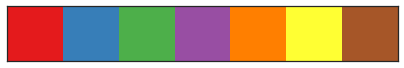

In [42]:
stackColors = sns.color_palette("Set1", 7)
sns.palplot(stackColors)

In [43]:
#http://stackoverflow.com/a/214657
def rgb2hex(rgb):
    return '#%02x%02x%02x' % rgb

In [44]:
def makeConfPlot(confDf,group,count):
    
    # we have 3 subplots here
    ax = plt.subplot(1,2,count)

    # order of face expressions is defined by hand here, instead of
    # using the columns, so the order is as we wish it to be
    faceExpressions = ['HA','NE','SP','AN','DI','SA','FE']
    faceAnswers = ['HAP','NTR','SUP','ANG','DIS','SAD','FEA']
    
    # we loop through all expressions
    for i,emo in enumerate( faceExpressions ):
        
        # since we build a stacked plot, we have to initialize a value that
        # tells us where to start. We start at the very bottom, hence 0
        sumSoFar = 0
        
        # we get the values of all conditions, and their names, as defined
        # in the index
        thisMean = confDf.loc[group][emo].mean()
        thisIndex = thisMean.index
        
        # firstly, we are interested in the correct response, which will be
        # always at the bottom of the stack plot and printed in a strong color
        
        # corrPos is the position of the current expression in the list of all expressions
        corrPos = faceExpressions.index(emo)
        # and we also get the name of the answer at this position (cave: the order of lists
        # must match!)
        corrEntry = faceAnswers[corrPos]

        # we get the positions of all the other answers
        incorrAnswers = faceAnswers[:corrPos]+faceAnswers[corrPos+1:]
        
        # we get the value of the correct answer
        entry = thisMean[corrEntry]
        # we get the name of the correct answer
        answer = faceAnswers[corrPos]
        
        # we take the color list and extract the color for the correct position
        thisColor = stackColors[corrPos]
        thisHex = rgb2hex( (thisColor[0]*255,thisColor[1]*255,thisColor[2]*255) )
        # the colors for the remaining 7-1 colors are stored here:
        incorrColors = stackColors[:corrPos]+stackColors[corrPos+1:]
        
            
        # this is the first bar we generate, it starts at the bottom (sumSoFar=0) and
        # has a strong color (alpha=1)
        ax.bar(i,
                entry,
                bottom=sumSoFar,
                color=thisHex,
                label=answer,
                alpha=1.)      
        
        # to stack the rest of the bars on top, we update the sum to be
        # the value (% correct) of the current condition
        sumSoFar = entry
        
        # we loop through the remaining (incorrect answers)
        for j,answer in enumerate(incorrAnswers):
            entry = thisMean[answer]

            thisColor = incorrColors[j]
            thisHex = rgb2hex( (thisColor[0]*255,thisColor[1]*255,thisColor[2]*255) )
            
            # same thing as above, but without the legend and with transparency
            ax.bar(i,
                    entry,
                    bottom=sumSoFar,
                    color=thisHex,
                    alpha=0.5
                        )           
            # for each run of the loop, we update the sumSoFar so we
            # always stack each expression at the top
            sumSoFar+=entry
    
    # get rid of figure box
    sns.despine()
    
    # x labels for each plot
    ax.set_xlabel('Basic Expression',fontsize=14)
    # y labels only for the first plot
    if i ==0:
        ax.set_ylabel('% of responses')
    else:
        ax.set_ylabel('')

    # axes annotation for all plots
    plt.xticks(np.arange(0,7.1,1), faceExpressions,fontsize=12)
    plt.yticks(np.arange(0,1.01,0.1), [str(a)+'%' for a in  np.arange(0,101,10)],fontsize=14)

    ax.set_ylim(0,1)
    
    # getting the name of each subplot right
    groupNames = {'JB':'JB',
                  'A':'controls',}
    ax.set_title(groupNames[group],position=(0.5,1.03) )
    
    # legend only at the very end (3rd plot)
    if count == 3:
        plt.legend(loc='best',bbox_to_anchor=[1,1])

In [45]:
def makeAllConfPlots(confDf):
    
    # loop through male and female faces
    for fGender in confDf.columns.levels[0][::-1]:
        
        plt.figure(figsize=(16,4))
        thisDf = confDf[fGender]
        
        # loop through participant groups
        for i,group in enumerate( ['JB','A'] ):
            makeConfPlot(thisDf,group,i+1)

        # each plot gets a title...
        titleDict = {'M':'Male Faces','F':'Female Faces'}
        plt.suptitle(titleDict[fGender], position=(0.5, 1.1),fontsize=20)
        # ...and is saved seperately under a differnt name
        plt.savefig('../faceEmotion/output/basicEmoPlot_'+fGender+'.png',
                    dpi=300,
                    bbox_inches='tight')
        # show in notebook
        plt.show()    

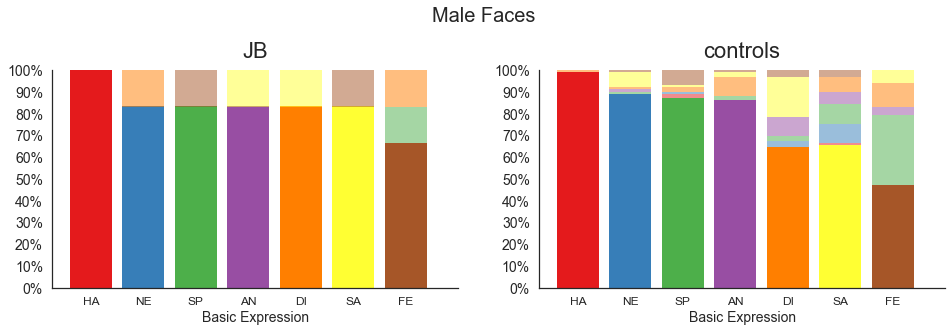

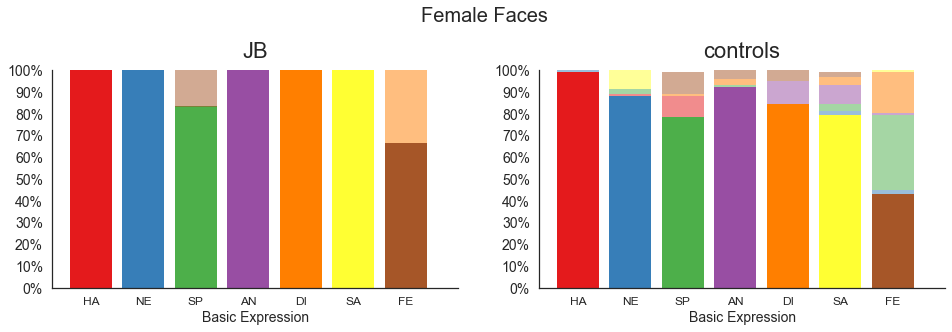

In [46]:
makeAllConfPlots(confDf)

## Getting a global emo score for each participant

This averages all correct responses, so we have one value per participant, which indicates percentage of correct responses overall.

In [47]:
bigDf.head()

cond              AN        DI        FE        HA        NE        SA  \
group id                                                                 
A     A_10  1.000000  0.750000  0.416667  1.000000  0.916667  0.916667   
      A_11  0.916667  0.916667  0.833333  1.000000  0.666667  0.666667   
      A_12  0.666667  0.666667  0.083333  1.000000  0.916667  0.750000   
      A_13  0.833333  0.916667  0.416667  1.000000  0.916667  0.750000   
      A_14  1.000000  0.833333  0.250000  0.916667  1.000000  0.750000   

cond              SP  
group id              
A     A_10  0.500000  
      A_11  0.916667  
      A_12  0.833333  
      A_13  1.000000  
      A_14  0.916667

### make overall percent correct and make swarmplot

In [48]:
globalCorrectDf = pd.DataFrame( bigDf.mean(axis=1) )*100
globalCorrectDf.columns = ['% correct']
globalCorrectDf['group'] = [['controls','JB'][x=='JB_001'] for x in globalCorrectDf.index.levels[1]]
globalCorrectDf['dummy'] = [0 for x in globalCorrectDf['group']]

In [49]:
globalCorrectDf.tail()

% correct     group  dummy
group id                                
A     A_6     83.333333  controls      0
      A_7     80.952381  controls      0
      A_8     85.714286  controls      0
      A_9     79.761905  controls      0
JB    JB_001  88.095238        JB      0

### Plot

In [50]:
sns.set_context('poster')
sns.set_style('white')

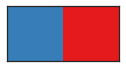

In [51]:
sns.set_palette(sns.color_palette('Set1',2)[::-1])
myPalette = sns.color_palette('Set1',2)[::-1]
sns.palplot(myPalette)

In [52]:
swarmFig,ax = plt.subplots(1,1,figsize=(6,4))
sns.swarmplot(data=globalCorrectDf,x='dummy',y='% correct',hue='group',
              size=18,orient='v',edgecolor='white',linewidth=1,alpha=0.8,ax=ax)
plt.xlabel('')
plt.legend(loc='lower right')
plt.xticks([])
plt.ylim(50,100)
plt.title('Recogition of basic emotions')
sns.despine()
plt.close()

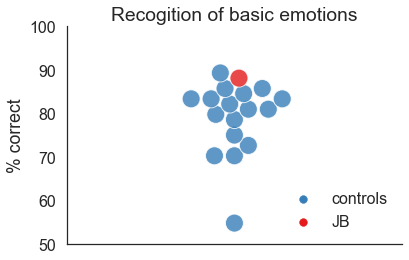

In [53]:
swarmFig

In [54]:
swarmFig.savefig('../faceEmotion/output/mainResults.png',bbox_inches='tight',dpi=300)

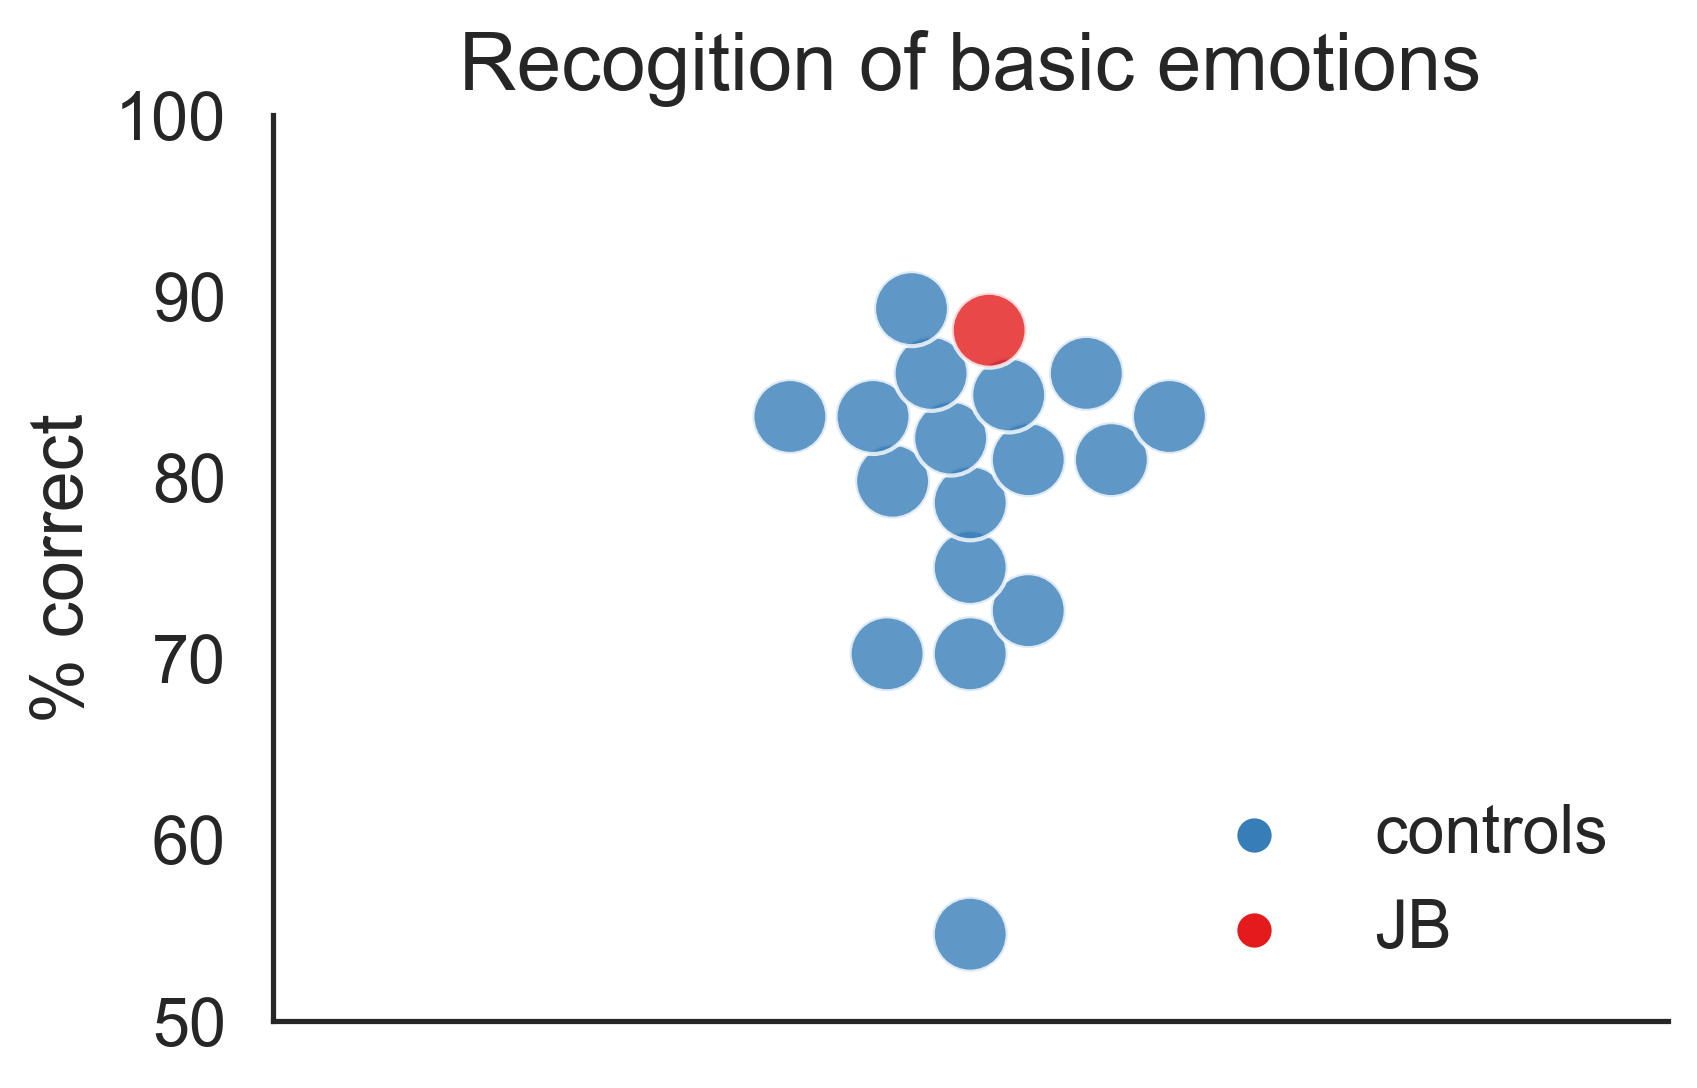

In [55]:
Image.open('../faceEmotion/output/mainResults.png')